In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import numpy as np
import seaborn as sns
import random
import time
import copy

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# ==============================
#  Updated Transform Pipeline (without Hair Removal)
# ==============================
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# ==============================
#  Load Dataset
# ==============================
data_path = '/kaggle/input/mosquito-dataset-for-classification-cnn/Mosquito_dataset'
full_dataset = datasets.ImageFolder(data_path, transform=transform_pipeline)
class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['AEDES', 'ANOPHELES', 'CULEX']


In [4]:
# # ==============================
# #  Train/Validation Split (70/30)
# # ==============================
# random_seed = 42
# random.seed(random_seed)
# indices = list(range(len(full_dataset)))
# train_idx, val_idx = train_test_split(
#     indices,
#     test_size=0.3,
#     stratify=[s[1] for s in full_dataset.samples],
#     random_state=random_seed
# )

# train_dataset = Subset(full_dataset, train_idx)
# val_dataset   = Subset(full_dataset, val_idx)


In [4]:
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# ==============================
#  Train/Validation/Test Split (70/15/15)
# ==============================
random_seed = 42
random.seed(random_seed)

# Assuming 'full_dataset' is your dataset object (e.g., ImageFolder or similar)
indices = list(range(len(full_dataset)))

# First, split into 70% for training and 30% for validation+test
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.3,
    stratify=[s[1] for s in full_dataset.samples],  # stratify by labels
    random_state=random_seed
)

# Now, split the remaining 30% into 50% validation and 50% test (i.e., 15% each)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[full_dataset.samples[i][1] for i in temp_idx],  # stratify by labels
    random_state=random_seed
)

# Create subsets for training, validation, and testing
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# Optional: Use DataLoader to load the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 2100
Validation dataset size: 450
Test dataset size: 450


In [5]:
# ==============================
#  Balance Train Dataset (Equal classes)
# ==============================
# Group indices by class
train_targets = [full_dataset.samples[i][1] for i in train_idx]
class_indices = {i: [idx for idx, t in zip(train_idx, train_targets) if t == i] for i in range(len(class_names))}

# Find minority class count
min_count = min(len(idxs) for idxs in class_indices.values())

# Undersample majority class
balanced_train_indices = []
for idxs in class_indices.values():
    balanced_train_indices.extend(random.sample(idxs, min_count))

balanced_train_dataset = Subset(full_dataset, balanced_train_indices)
print("Balanced train dataset size:", len(balanced_train_dataset))


Balanced train dataset size: 2100


In [7]:
from torch.utils.data import DataLoader

# ==============================
#  DataLoaders
# ==============================
train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)  # Balanced training dataset
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)             # Validation dataset
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)            # Test dataset

# Optionally, print the sizes of the DataLoaders
print(f"Training DataLoader size: {len(train_loader.dataset)}")
print(f"Validation DataLoader size: {len(val_loader.dataset)}")
print(f"Test DataLoader size: {len(test_loader.dataset)}")

Training DataLoader size: 2100
Validation DataLoader size: 450
Test DataLoader size: 450


In [8]:
# ==============================
#  Fixed show_images function
# ==============================
def show_images(images, labels, class_names):
    n_images = len(images)
    n_cols = 5
    n_rows = (n_images + n_cols - 1) // n_cols  # auto rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    
    # axs shape handling if only 1 row
    if n_rows == 1:
        axs = np.expand_dims(axs, 0)
    
    axs = axs.ravel()
    
    for i in range(n_images):
        img = images[i].numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axs[i].imshow(img)
        axs[i].set_title(f"{class_names[labels[i]]}")
        axs[i].axis("off")
    
    # Turn off any unused axes
    for j in range(n_images, len(axs)):
        axs[j].axis("off")
    
    plt.tight_layout()
    plt.show()


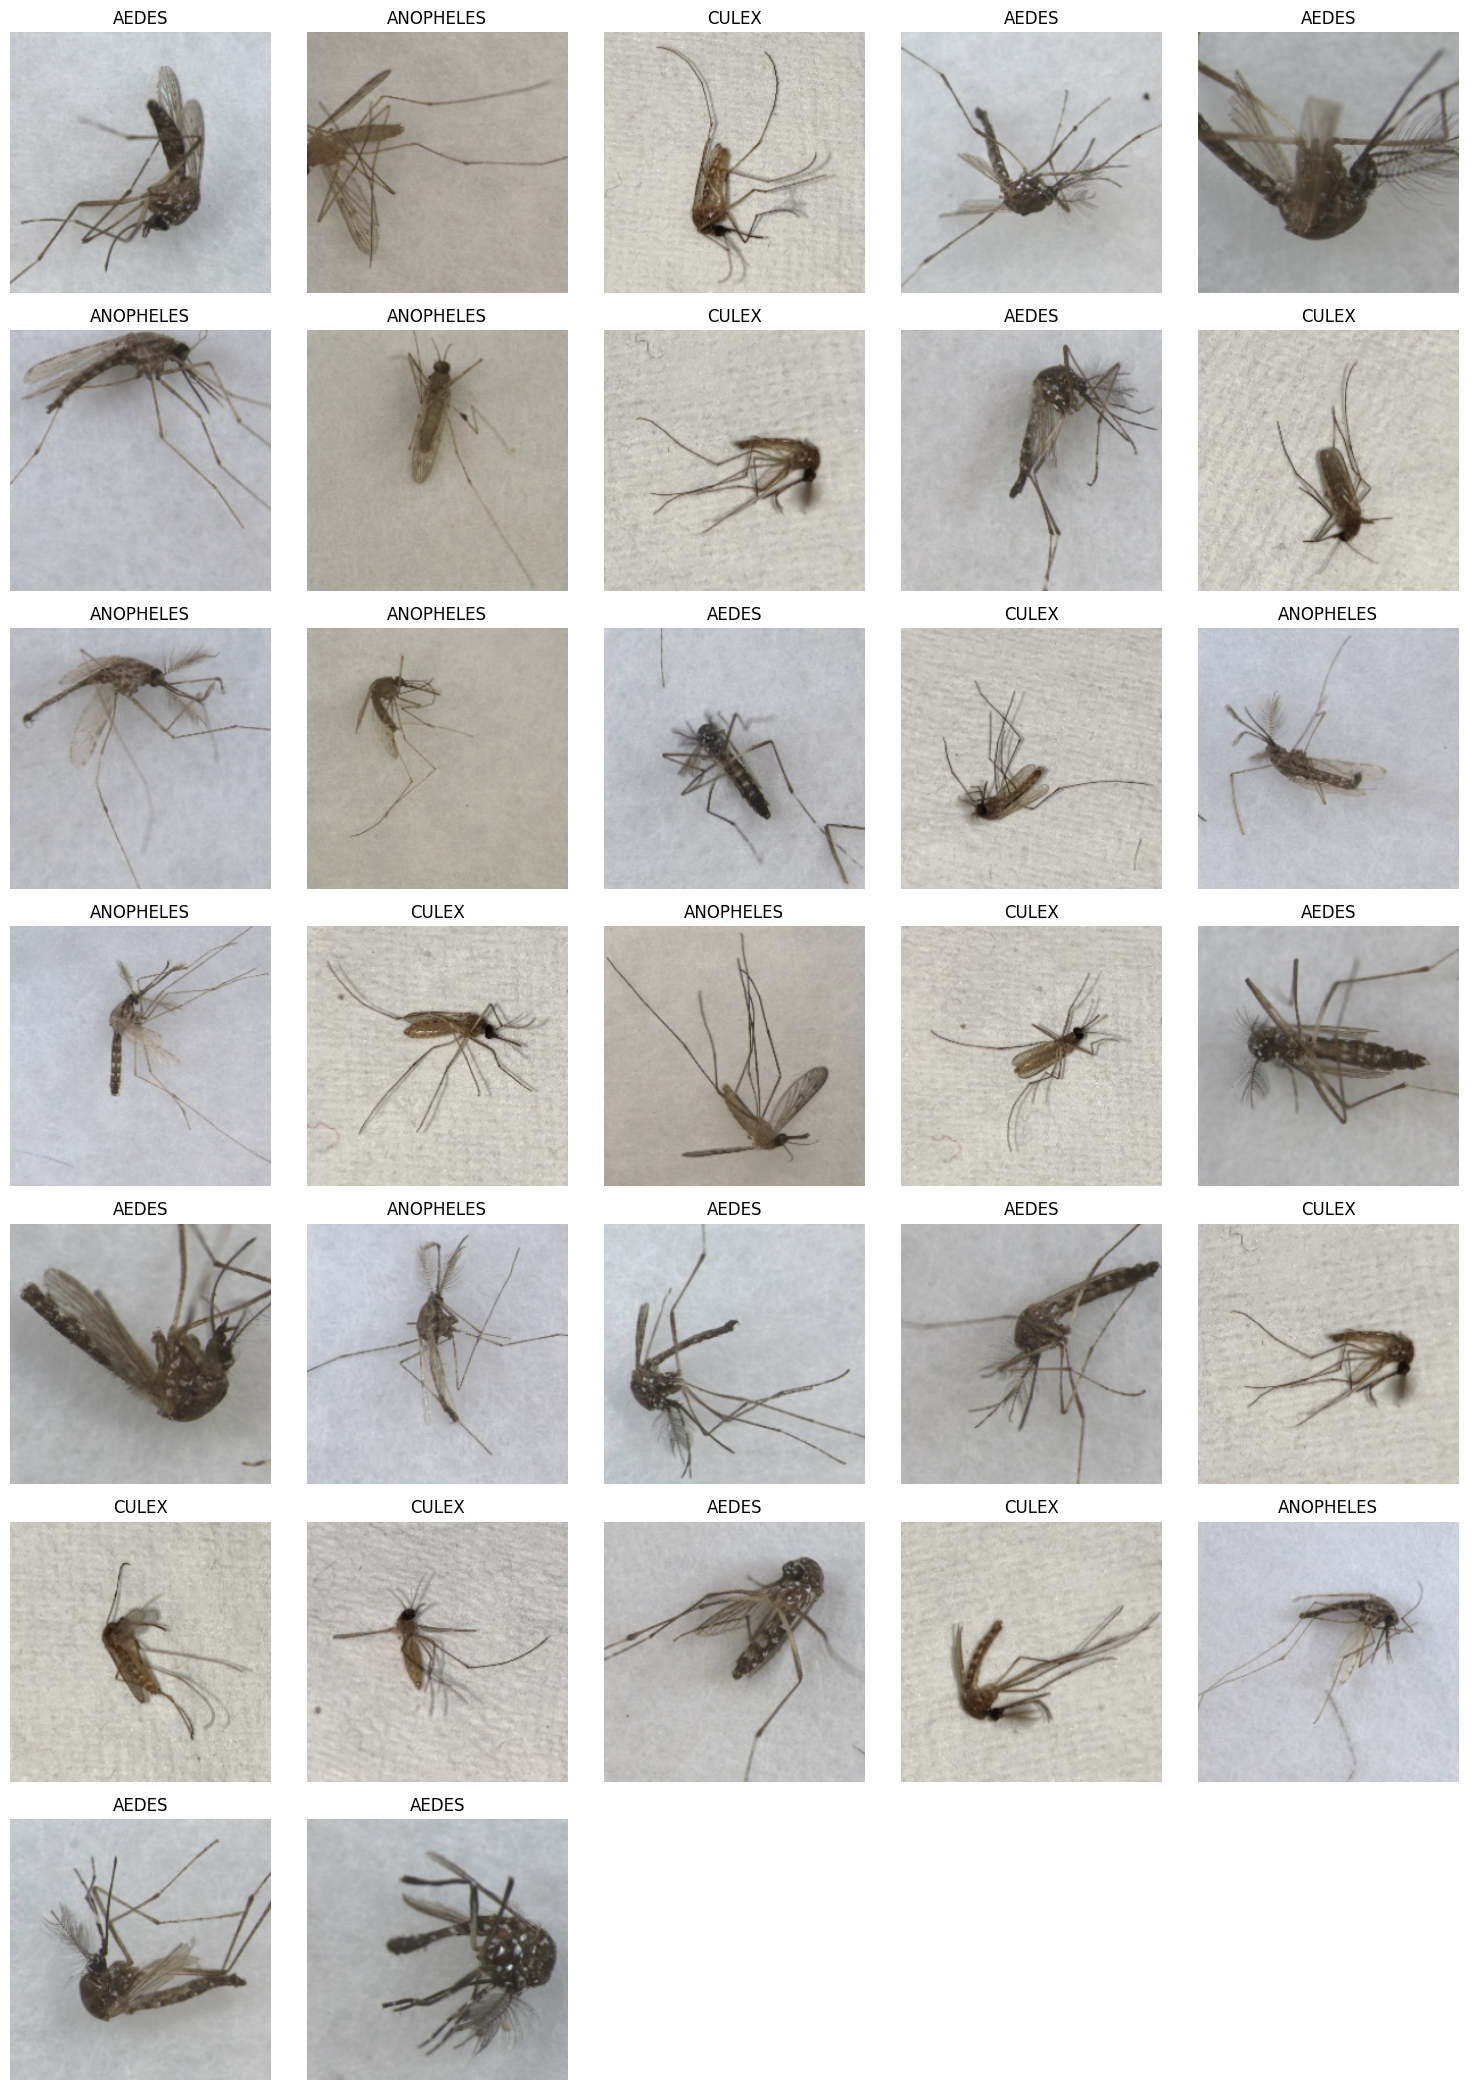

In [9]:
# ==============================
#  Display a random batch of balanced train dataset
# ==============================
images, labels = next(iter(train_loader))
show_images(images, labels, class_names)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


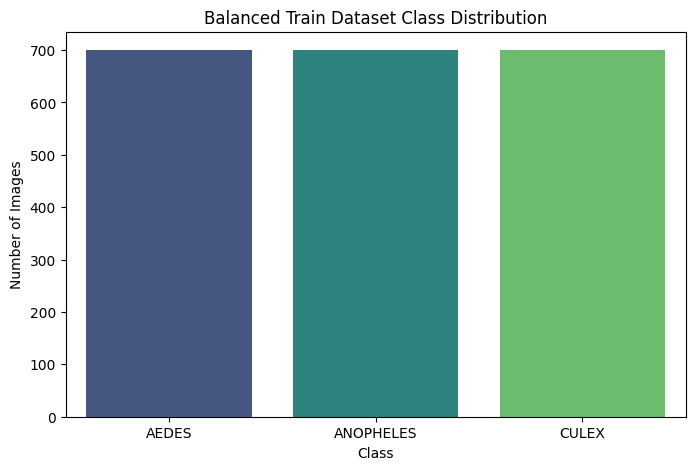

In [10]:
# ==============================
#  Plot class distribution in balanced train dataset
# ==============================
train_labels = [full_dataset.samples[i][1] for i in balanced_train_indices]
plt.figure(figsize=(8,5))
sns.countplot(x=train_labels, palette="viridis")
plt.title("Balanced Train Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.show()

In [11]:
# ==============================
#  Model Definition
# ==============================
class CustomModel(nn.Module):
    def __init__(self, num_classes, hidden_sizes=[256, 128]):
        super(CustomModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=False)

        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Identity()

        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(num_features, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            num_features = hidden_size
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        features = self.mobilenet(x)
        output = self.classifier(features)
        return F.softmax(output, dim=1)

In [11]:
# # ==============================
# #  Model Definition (Using ResNet50)
# # ==============================
# class CustomModel(nn.Module):
#     def __init__(self, num_classes, hidden_sizes=[256, 128]):
#         super(CustomModel, self).__init__()
        
#         # Using ResNet50 pre-trained model
#         self.resnet50 = models.resnet50(pretrained=True)

#         # Freeze the ResNet50 layers to prevent training during the initial phase (optional)
#         for param in self.resnet50.parameters():
#             param.requires_grad = False
        
#         # Replace the final fully connected layer (fc) with a custom classifier
#         num_features = self.resnet50.fc.in_features
#         self.resnet50.fc = nn.Identity()  # Remove the final fc layer
        
#         layers = []
#         for hidden_size in hidden_sizes:
#             layers.append(nn.Linear(num_features, hidden_size))
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             num_features = hidden_size
#         layers.append(nn.Linear(hidden_sizes[-1], num_classes))
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, x):
#         features = self.resnet50(x)
#         output = self.classifier(features)
#         return F.softmax(output, dim=1)


In [12]:
# # ==============================
# #  Model Definition (Using VGG16)
# # ==============================
# class CustomModel(nn.Module):
#     def __init__(self, num_classes, hidden_sizes=[256, 128]):
#         super(CustomModel, self).__init__()
        
#         # Using VGG16 pre-trained model
#         self.vgg16 = models.vgg16(pretrained=True)

#         # Freeze the VGG16 layers to prevent training during the initial phase (optional)
#         for param in self.vgg16.parameters():
#             param.requires_grad = False
        
#         # Replace the final fully connected layer (fc) with a custom classifier
#         num_features = self.vgg16.classifier[6].in_features  # Get the input features of the final fc layer
#         self.vgg16.classifier = nn.Identity()  # Remove the final fc layer
        
#         # Add new custom classifier layers
#         layers = []
#         for hidden_size in hidden_sizes:
#             layers.append(nn.Linear(num_features, hidden_size))
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             num_features = hidden_size
#         layers.append(nn.Linear(hidden_sizes[-1], num_classes))
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, x):
#         features = self.vgg16(x)  # Get features from VGG16
#         output = self.classifier(features)  # Pass the features through the new classifier
#         return F.softmax(output, dim=1)


In [13]:
# # ==============================
# #  Model Definition (Using ViT)
# # ==============================
# class CustomModel(nn.Module):
#     def __init__(self, num_classes, hidden_sizes=[256, 128]):
#         super(CustomModel, self).__init__()

#         # Using Vision Transformer (ViT) pre-trained model
#         self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)

#         # Freeze the ViT layers to prevent training during the initial phase (optional)
#         for param in self.vit.parameters():
#             param.requires_grad = False
        
#         # Remove the original classifier head and replace with our own
#         num_features = self.vit.head.in_features
#         self.vit.head = nn.Identity()  # Remove the original classification head
        
#         # Add custom classifier layers
#         layers = []
#         for hidden_size in hidden_sizes:
#             layers.append(nn.Linear(num_features, hidden_size))
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             num_features = hidden_size
#         layers.append(nn.Linear(hidden_sizes[-1], num_classes))
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, x):
#         features = self.vit(x)
#         output = self.classifier(features)
#         return F.softmax(output, dim=1)

In [14]:
# import torch.nn as nn
# import torch
# import torch.nn.functional as F
# import torchvision.models as models

# # ==============================
# #  Model Definition (Using InceptionV2)
# # ==============================
# class CustomModel(nn.Module):
#     def __init__(self, num_classes, hidden_sizes=[256, 128]):
#         super(CustomModel, self).__init__()

#         # Using InceptionV2 pre-trained model
#         self.inception_v2 = models.inception_v3(pretrained=True)

#         # Freeze the InceptionV2 layers to prevent training during the initial phase (optional)
#         for param in self.inception_v2.parameters():
#             param.requires_grad = False

#         # Remove the original classifier head and replace with our own
#         num_features = self.inception_v2.fc.in_features
#         self.inception_v2.fc = nn.Identity()  # Remove the original fully connected layer (classifier)
        
#         # Add custom classifier layers
#         layers = []
#         for hidden_size in hidden_sizes:
#             layers.append(nn.Linear(num_features, hidden_size))
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             num_features = hidden_size
#         layers.append(nn.Linear(hidden_sizes[-1], num_classes))
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, x):
#         # Pass through the InceptionV2 model
#         inception_output = self.inception_v2(x)  # This returns InceptionOutputs object
#         features = inception_output[0]  # Get the main output (the first element)
#         output = self.classifier(features)  # Pass the features to the custom classifier
#         return F.softmax(output, dim=1)


In [15]:
# import torch.nn as nn
# import torch
# import torch.nn.functional as F
# import timm  # For using EfficientNetB7 from the timm library

# # ==============================
# #  Model Definition (Using EfficientNetB7)
# # ==============================
# class CustomModel(nn.Module):
#     def __init__(self, num_classes, hidden_sizes=[256, 128]):
#         super(CustomModel, self).__init__()

#         # Using EfficientNetB7 pre-trained model from timm
#         self.efficientnet_b7 = timm.create_model('efficientnet_b7', pretrained=True)

#         # Freeze the EfficientNetB7 layers to prevent training during the initial phase (optional)
#         for param in self.efficientnet_b7.parameters():
#             param.requires_grad = False

#         # Remove the original classifier head and replace with our own
#         num_features = self.efficientnet_b7.classifier.in_features
#         self.efficientnet_b7.classifier = nn.Identity()  # Remove the original fully connected layer (classifier)
        
#         # Add custom classifier layers
#         layers = []
#         for hidden_size in hidden_sizes:
#             layers.append(nn.Linear(num_features, hidden_size))
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             num_features = hidden_size
#         layers.append(nn.Linear(hidden_sizes[-1], num_classes))
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, x):
#         # Pass through the EfficientNetB7 model
#         features = self.efficientnet_b7(x)  # Get the main output (the features)
#         output = self.classifier(features)  # Pass the features to the custom classifier
#         return F.softmax(output, dim=1)


In [16]:
# import torch.nn as nn
# import torch
# import torch.nn.functional as F
# import torchvision.models as models

# # ==============================
# #  Model Definition (Using VGG19)
# # ==============================
# class CustomModel(nn.Module):
#     def __init__(self, num_classes, hidden_sizes=[256, 128]):
#         super(CustomModel, self).__init__()

#         # Using VGG19 pre-trained model
#         self.vgg19 = models.vgg19(pretrained=True)

#         # Freeze the VGG19 layers to prevent training during the initial phase (optional)
#         for param in self.vgg19.parameters():
#             param.requires_grad = False

#         # Remove the original classifier head and replace with our own
#         num_features = self.vgg19.classifier[6].in_features  # VGG19's last classifier layer in_features
#         self.vgg19.classifier = nn.Identity()  # Remove the original fully connected layer (classifier)
        
#         # Add custom classifier layers
#         layers = []
#         for hidden_size in hidden_sizes:
#             layers.append(nn.Linear(num_features, hidden_size))  # Now the input size must match VGG19's output
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             num_features = hidden_size
#         layers.append(nn.Linear(hidden_sizes[-1], num_classes))  # Output layer for the desired number of classes
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, x):
#         # Pass through the VGG19 model
#         features = self.vgg19(x)  # Get the main output (the features)
        
#         # Flatten the features
#         features = features.view(features.size(0), -1)  # Flatten the tensor to a 1D vector for each image
        
#         # Pass the flattened features to the custom classifier
#         output = self.classifier(features)
#         return F.softmax(output, dim=1)


In [17]:
# import torch.nn as nn
# import torch
# import torch.nn.functional as F
# import torchvision.models as models

# # ==============================
# #  Model Definition (Using DenseNet-121)
# # ==============================
# class CustomModel(nn.Module):
#     def __init__(self, num_classes, hidden_sizes=[256, 128]):
#         super(CustomModel, self).__init__()

#         # Using DenseNet-121 pre-trained model
#         self.densenet121 = models.densenet121(pretrained=True)

#         # Freeze the DenseNet-121 layers to prevent training during the initial phase (optional)
#         for param in self.densenet121.parameters():
#             param.requires_grad = False

#         # Remove the original classifier head and replace with our own
#         num_features = self.densenet121.classifier.in_features  # DenseNet-121's last classifier layer in_features
#         self.densenet121.classifier = nn.Identity()  # Remove the original fully connected layer (classifier)
        
#         # Add custom classifier layers
#         layers = []
#         for hidden_size in hidden_sizes:
#             layers.append(nn.Linear(num_features, hidden_size))  # Now the input size must be 1024
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             num_features = hidden_size
#         layers.append(nn.Linear(hidden_sizes[-1], num_classes))  # Output layer for the desired number of classes
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, x):
#         # Pass through the DenseNet-121 model
#         features = self.densenet121(x)  # Get the main output (the features)
        
#         # Flatten the features
#         features = features.view(features.size(0), -1)  # Flatten the tensor to a 1D vector for each image
        
#         # Pass the flattened features to the custom classifier
#         output = self.classifier(features)
#         return F.softmax(output, dim=1)


In [18]:
# import torch.nn as nn
# import torch
# import torch.nn.functional as F
# import torchvision.models as models

# # ==============================
# #  Model Definition (Using DenseNet-169)
# # ==============================
# class CustomModel(nn.Module):
#     def __init__(self, num_classes, hidden_sizes=[256, 128]):
#         super(CustomModel, self).__init__()

#         # Using DenseNet-169 pre-trained model
#         self.densenet169 = models.densenet169(pretrained=True)

#         # Freeze the DenseNet-169 layers to prevent training during the initial phase (optional)
#         for param in self.densenet169.parameters():
#             param.requires_grad = False

#         # Remove the original classifier head and replace with our own
#         num_features = self.densenet169.classifier.in_features  # DenseNet-169's last classifier layer in_features
#         self.densenet169.classifier = nn.Identity()  # Remove the original fully connected layer (classifier)
        
#         # Add custom classifier layers
#         layers = []
#         for hidden_size in hidden_sizes:
#             layers.append(nn.Linear(num_features, hidden_size))  # Now the input size must match DenseNet-169's output size
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             num_features = hidden_size
#         layers.append(nn.Linear(hidden_sizes[-1], num_classes))  # Output layer for the desired number of classes
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, x):
#         # Pass through the DenseNet-169 model
#         features = self.densenet169(x)  # Get the main output (the features)
        
#         # Flatten the features
#         features = features.view(features.size(0), -1)  # Flatten the tensor to a 1D vector for each image
        
#         # Pass the flattened features to the custom classifier
#         output = self.classifier(features)
#         return F.softmax(output, dim=1)


In [12]:
# ==============================
#  Device Setup
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
model = CustomModel(num_classes=num_classes).to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# ==============================
#  Training Setup
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
num_epochs = 20
from sklearn.metrics import precision_score, recall_score, f1_score

# ==============================
#  Training Loop
# ==============================
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    all_train_preds, all_train_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for training data
    train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
    train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    # Validation Phase
    model.eval()
    val_loss, val_corrects = 0.0, 0
    all_val_preds, all_val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for validation data
    val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    # Test Phase (After each epoch or at the end of the training)
    model.eval()
    test_loss, test_corrects = 0.0, 0
    all_test_preds, all_test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects.double() / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for test data
    test_precision = precision_score(all_test_labels, all_test_preds, average='weighted')
    test_recall = recall_score(all_test_labels, all_test_preds, average='weighted')
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

    # Print the metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Precision: {val_precision:.4f} | "
          f"Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Precision: {test_precision:.4f} | "
          f"Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")

    scheduler.step()

In [13]:
from colorama import Fore

# ==============================
#  Training Setup
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
num_epochs = 20
from sklearn.metrics import precision_score, recall_score, f1_score

# ==============================
#  Training Loop
# ==============================
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    all_train_preds, all_train_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for training data
    train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
    train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    # Validation Phase
    model.eval()
    val_loss, val_corrects = 0.0, 0
    all_val_preds, all_val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for validation data
    val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    # Test Phase (After each epoch or at the end of the training)
    model.eval()
    test_loss, test_corrects = 0.0, 0
    all_test_preds, all_test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects.double() / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for test data
    test_precision = precision_score(all_test_labels, all_test_preds, average='weighted')
    test_recall = recall_score(all_test_labels, all_test_preds, average='weighted')
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

    # Print the metrics with different colors for Training, Validation, and Test
    print(f"{Fore.GREEN}Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f} | Train F1: {train_f1:.4f} | "
          f"{Fore.YELLOW}Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Precision: {val_precision:.4f} | "
          f"Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f} | "
          f"{Fore.RED}Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Precision: {test_precision:.4f} | "
          f"Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}{Fore.RESET}")

    scheduler.step()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20] | Train Loss: 0.7022 | Train Acc: 0.8629 | Train Precision: 0.8613 | Train Recall: 0.8629 | Train F1: 0.8614 | Val Loss: 1.2181 | Val Acc: 0.3333 | Val Precision: 0.1111 | Val Recall: 0.3333 | Val F1: 0.1667 | Test Loss: 1.2181 | Test Acc: 0.3333 | Test Precision: 0.1111 | Test Recall: 0.3333 | Test F1: 0.1667
Epoch [2/20] | Train Loss: 0.6262 | Train Acc: 0.9252 | Train Precision: 0.9259 | Train Recall: 0.9252 | Train F1: 0.9252 | Val Loss: 0.9895 | Val Acc: 0.5533 | Val Precision: 0.8091 | Val Recall: 0.5533 | Val F1: 0.5299 | Test Loss: 0.9494 | Test Acc: 0.5911 | Test Precision: 0.8164 | Test Recall: 0.5911 | Test F1: 0.5752
Epoch [3/20] | Train Loss: 0.6078 | Train Acc: 0.9452 | Train Precision: 0.9456 | Train Recall: 0.9452 | Train F1: 0.9453 | Val Loss: 0.6675 | Val Acc: 0.8867 | Val Precision: 0.9154 | Val Recall: 0.8867 | Val F1: 0.8833 | Test Loss: 0.6654 | Test Acc: 0.8867 | Test Precision: 0.9154 | Test Recall: 0.8867 | Test F1: 0.8833
Epoch [4/20] | Train Loss

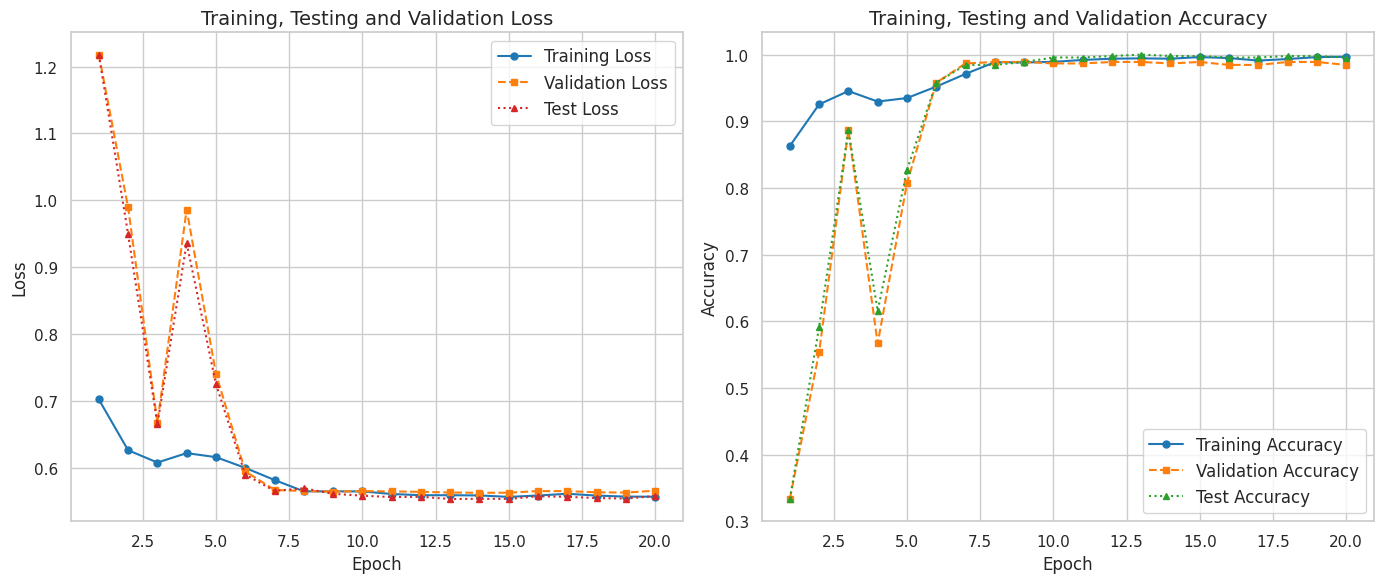

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots to make them visually appealing and suitable for Q1 standards
sns.set(style="whitegrid")

# ==============================
#  Plotting Accuracy and Loss
# ==============================
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, test_losses=None, test_accuracies=None):
    epochs = range(1, num_epochs + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(epochs, train_losses, label='Training Loss', color='tab:blue', marker='o', linestyle='-', markersize=5)
    plt.plot(epochs, val_losses, label='Validation Loss', color='tab:orange', marker='s', linestyle='--', markersize=5)
    if test_losses:
        plt.plot(epochs, test_losses, label='Test Loss', color='tab:red', marker='^', linestyle=':', markersize=5)  # Optional: Include test loss if available
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training, Testing and Validation Loss', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='tab:blue', marker='o', linestyle='-', markersize=5)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='tab:orange', marker='s', linestyle='--', markersize=5)
    if test_accuracies:
        plt.plot(epochs, test_accuracies, label='Test Accuracy', color='tab:green', marker='^', linestyle=':', markersize=5)  # Optional: Include test accuracy if available
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training, Testing and Validation Accuracy', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

# ==============================
#  After Training Loop
# ==============================
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, test_losses, test_accuracies)

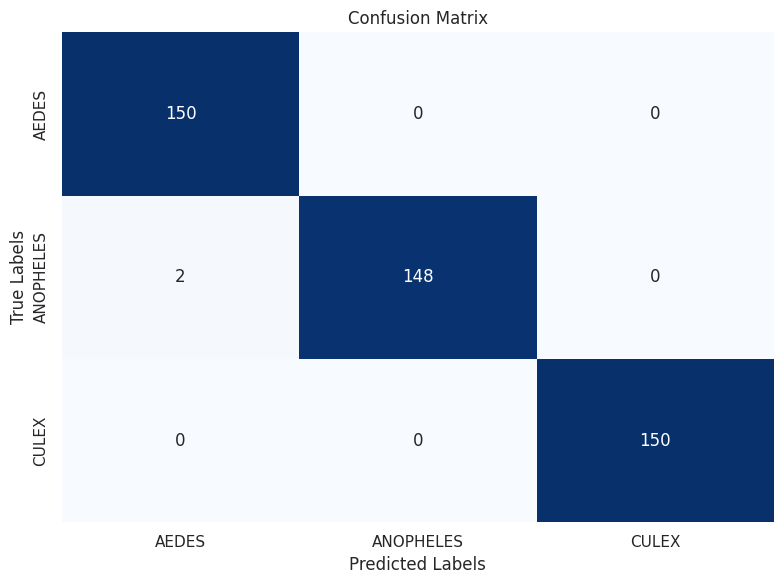

Confusion Matrix:
[[150   0   0]
 [  2 148   0]
 [  0   0 150]]


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ==============================
#  Function to plot Confusion Matrix
# ==============================
def plot_confusion_matrix(true_labels, pred_labels, classes, fold):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(f"Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

    # Optionally print the confusion matrix
    print(f"Confusion Matrix:")
    print(cm)

# ==============================
#  After Training Loop (or after each epoch)
# ==============================
# Assuming you have all the predicted and true labels from your test set:
all_test_preds = np.array(all_test_preds)  # Test predictions
all_test_labels = np.array(all_test_labels)  # Test true labels
class_names = ['AEDES', 'ANOPHELES', 'CULEX']  # Replace with your actual class names

# Plot the confusion matrix for the test set (after the final epoch or after each epoch)
plot_confusion_matrix(all_test_labels, all_test_preds, class_names, fold=0)

In [23]:
from sklearn.metrics import classification_report
import numpy as np

# ==============================
#  Function to Calculate and Display Classwise Metrics
# ==============================
def print_classwise_metrics(true_labels, pred_labels, phase_name):
    # Generate the classification report
    report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
    
    # Print class-wise accuracy, precision, recall, F1-score
    print(f"\n{phase_name} - Classification Report:")
    print(f"Classwise Precision, Recall, F1-score for {phase_name}:")
    print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-score':<10}{'Accuracy':<10}")
    
    for class_name in class_names:
        print(f"{class_name:<15}{report[class_name]['precision']:<10.4f}{report[class_name]['recall']:<10.4f}{report[class_name]['f1-score']:<10.4f}{report[class_name]['support'] / len(true_labels):<10.4f}")
    
    # Print overall metrics (macro avg and weighted avg)
    print(f"\nOverall Metrics (Macro avg / Weighted avg):")
    print(f"Precision (Macro): {report['macro avg']['precision']:.4f}")
    print(f"Recall (Macro): {report['macro avg']['recall']:.4f}")
    print(f"F1-score (Macro): {report['macro avg']['f1-score']:.4f}")
    print(f"Accuracy: {report['accuracy']:.4f}")

# ==============================
#  Training Loop (updated with classwise metrics)
# ==============================
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    all_train_preds, all_train_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.cpu().numpy())

    # Call function to print classwise metrics for training phase
    print_classwise_metrics(all_train_labels, all_train_preds, "Training")

    # Validation Phase
    model.eval()
    val_loss, val_corrects = 0.0, 0
    all_val_preds, all_val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())

    # Call function to print classwise metrics for validation phase
    print_classwise_metrics(all_val_labels, all_val_preds, "Validation")

    # Test Phase (After each epoch)
    model.eval()
    test_loss, test_corrects = 0.0, 0
    all_test_preds, all_test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects.double() / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc.cpu().numpy())

    # Call function to print classwise metrics for test phase
    print_classwise_metrics(all_test_labels, all_test_preds, "Test")

    # Print overall metrics (optional)
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    scheduler.step()


Training - Classification Report:
Classwise Precision, Recall, F1-score for Training:
Class          Precision Recall    F1-score  Accuracy  
AEDES          0.9815    0.9871    0.9843    0.3333    
ANOPHELES      0.9871    0.9829    0.9850    0.3333    
CULEX          1.0000    0.9986    0.9993    0.3333    

Overall Metrics (Macro avg / Weighted avg):
Precision (Macro): 0.9895
Recall (Macro): 0.9895
F1-score (Macro): 0.9895
Accuracy: 0.9895

Validation - Classification Report:
Classwise Precision, Recall, F1-score for Validation:
Class          Precision Recall    F1-score  Accuracy  
AEDES          0.9739    0.9933    0.9835    0.3333    
ANOPHELES      0.9932    0.9733    0.9832    0.3333    
CULEX          1.0000    1.0000    1.0000    0.3333    

Overall Metrics (Macro avg / Weighted avg):
Precision (Macro): 0.9890
Recall (Macro): 0.9889
F1-score (Macro): 0.9889
Accuracy: 0.9889

Test - Classification Report:
Classwise Precision, Recall, F1-score for Test:
Class          Precisio

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# ==============================
#  Training Loop
# ==============================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    all_train_preds, all_train_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for training data
    train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
    train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    all_val_preds, all_val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for validation data
    val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Precision: {val_precision:.4f} | "
          f"Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}")
    
    scheduler.step()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20] | Train Loss: 0.6815 | Train Acc: 0.8886 | Train Precision: 0.8887 | Train Recall: 0.8886 | Train F1: 0.8886 | Val Loss: 1.2181 | Val Acc: 0.3333 | Val Precision: 0.1111 | Val Recall: 0.3333 | Val F1: 0.1667
Epoch [2/20] | Train Loss: 0.6195 | Train Acc: 0.9357 | Train Precision: 0.9360 | Train Recall: 0.9357 | Train F1: 0.9357 | Val Loss: 0.6643 | Val Acc: 0.8844 | Val Precision: 0.9132 | Val Recall: 0.8844 | Val F1: 0.8806
Epoch [3/20] | Train Loss: 0.6287 | Train Acc: 0.9190 | Train Precision: 0.9193 | Train Recall: 0.9190 | Train F1: 0.9192 | Val Loss: 0.6195 | Val Acc: 0.9289 | Val Precision: 0.9307 | Val Recall: 0.9289 | Val F1: 0.9291
Epoch [4/20] | Train Loss: 0.5935 | Train Acc: 0.9595 | Train Precision: 0.9596 | Train Recall: 0.9595 | Train F1: 0.9595 | Val Loss: 0.8790 | Val Acc: 0.6600 | Val Precision: 0.7832 | Val Recall: 0.6600 | Val F1: 0.6290
Epoch [5/20] | Train Loss: 0.5911 | Train Acc: 0.9619 | Train Precision: 0.9620 | Train Recall: 0.9619 | Train F1: 0

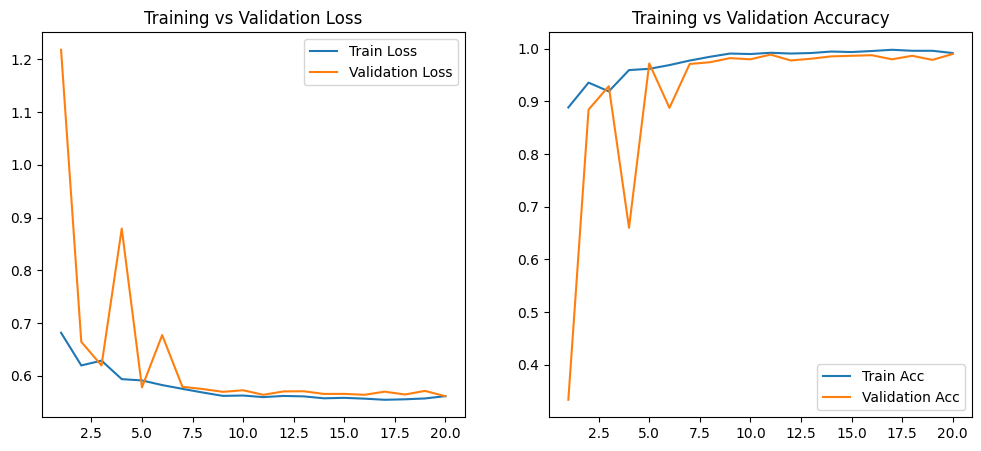

In [16]:
# ==============================
#  Plot Loss & Accuracy
# ==============================
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.legend(); plt.title("Training vs Validation Loss")
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Validation Acc')
plt.legend(); plt.title("Training vs Validation Accuracy")
plt.show()

In [18]:
import pandas as pd

# ==============================
# Initialize DataFrame for Performance Summary
# ==============================
columns = ['Epoch', 'Train Loss', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1', 
           'Val Loss', 'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1']
performance_summary = []

# ==============================
# Add Performance Metrics to the Summary
# ==============================
for epoch in range(num_epochs):
    performance_summary.append([epoch+1, train_losses[epoch], train_accuracies[epoch], 
                               train_precision, train_recall, train_f1, 
                               val_losses[epoch], val_accuracies[epoch], val_precision, 
                               val_recall, val_f1])

# ==============================
# Create DataFrame for Performance Summary
# ==============================
performance_df = pd.DataFrame(performance_summary, columns=columns)

# Display the performance matrix summary
print(performance_df)

    Epoch  Train Loss      Train Accuracy  Train Precision  Train Recall  \
0       1    0.681502  0.8885714285714286         0.991916      0.991905   
1       2    0.619492  0.9357142857142857         0.991916      0.991905   
2       3    0.628657   0.919047619047619         0.991916      0.991905   
3       4    0.593540  0.9595238095238096         0.991916      0.991905   
4       5    0.591086  0.9619047619047619         0.991916      0.991905   
5       6    0.582256   0.969047619047619         0.991916      0.991905   
6       7    0.575157  0.9776190476190476         0.991916      0.991905   
7       8    0.568231  0.9847619047619047         0.991916      0.991905   
8       9    0.561780  0.9909523809523809         0.991916      0.991905   
9      10    0.562467                0.99         0.991916      0.991905   
10     11    0.559447  0.9923809523809524         0.991916      0.991905   
11     12    0.561682  0.9909523809523809         0.991916      0.991905   
12     13   

In [19]:
import pandas as pd

# ==============================
# Initialize DataFrame for Performance Summary
# ==============================
columns = ['Epoch', 'Train Loss', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1', 
           'Val Loss', 'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1']
performance_summary = []

# ==============================
# Add Performance Metrics to the Summary
# ==============================
for epoch in range(num_epochs):
    performance_summary.append([epoch+1, train_losses[epoch], train_accuracies[epoch], 
                               train_precision, train_recall, train_f1, 
                               val_losses[epoch], val_accuracies[epoch], val_precision, 
                               val_recall, val_f1])

# ==============================
# Create DataFrame for Performance Summary
# ==============================
performance_df = pd.DataFrame(performance_summary, columns=columns)

# ==============================
# Calculate Averages for All Metrics
# ==============================
avg_train_loss = sum(train_losses) / num_epochs
avg_train_acc = sum(train_accuracies) / num_epochs
avg_train_precision = sum([train_precision for _ in range(num_epochs)]) / num_epochs  # Assuming precision is constant across epochs
avg_train_recall = sum([train_recall for _ in range(num_epochs)]) / num_epochs  # Assuming recall is constant across epochs
avg_train_f1 = sum([train_f1 for _ in range(num_epochs)]) / num_epochs  # Assuming F1 is constant across epochs

avg_val_loss = sum(val_losses) / num_epochs
avg_val_acc = sum(val_accuracies) / num_epochs
avg_val_precision = sum([val_precision for _ in range(num_epochs)]) / num_epochs  # Assuming precision is constant across epochs
avg_val_recall = sum([val_recall for _ in range(num_epochs)]) / num_epochs  # Assuming recall is constant across epochs
avg_val_f1 = sum([val_f1 for _ in range(num_epochs)]) / num_epochs  # Assuming F1 is constant across epochs

# Add Average Row to the DataFrame
performance_df.loc['Average'] = ['Average', avg_train_loss, avg_train_acc, avg_train_precision, 
                                 avg_train_recall, avg_train_f1, avg_val_loss, avg_val_acc, 
                                 avg_val_precision, avg_val_recall, avg_val_f1]

# Display the performance matrix summary
print(performance_df)

           Epoch  Train Loss      Train Accuracy  Train Precision  \
0              1    0.681502  0.8885714285714286         0.991916   
1              2    0.619492  0.9357142857142857         0.991916   
2              3    0.628657   0.919047619047619         0.991916   
3              4    0.593540  0.9595238095238096         0.991916   
4              5    0.591086  0.9619047619047619         0.991916   
5              6    0.582256   0.969047619047619         0.991916   
6              7    0.575157  0.9776190476190476         0.991916   
7              8    0.568231  0.9847619047619047         0.991916   
8              9    0.561780  0.9909523809523809         0.991916   
9             10    0.562467                0.99         0.991916   
10            11    0.559447  0.9923809523809524         0.991916   
11            12    0.561682  0.9909523809523809         0.991916   
12            13    0.560851   0.991904761904762         0.991916   
13            14    0.557212  0.99